<a href="https://colab.research.google.com/github/praveenraghuvanshi1512/EIP4/blob/master/Session5/Assignment5/EIP4_A5_Praveen_Raghuvanshi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

In [207]:
# %tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

# from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

In [29]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


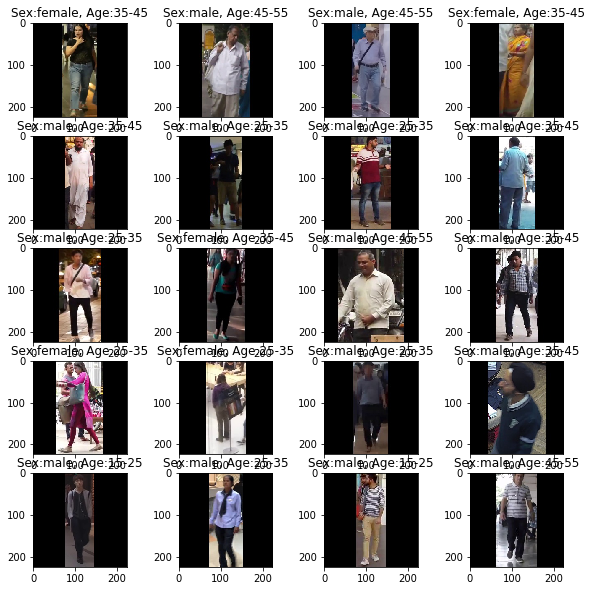

Attributes of image at index: 1
gender                  female
imagequality           Average
age                      35-45
weight             over-weight
carryingbag               None
footwear                Normal
emotion          Angry/Serious
bodypose        Front-Frontish
image_path       resized/2.jpg
Name: 1, dtype: object


In [84]:
# Print random image
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
ax = []

for i in range(1, columns * rows + 1):
    
    x = mpimg.imread(df.image_path[i])
    ax.append(fig.add_subplot(rows, columns, i))
    ax[-1].set_title("Sex:"+str(df.gender[i])+", Age:"+str(df.age[i]))
    plt.imshow(x)

plt.show()


imageIndex = 1
print("Attributes of image at index: " + str(imageIndex))
print(df.iloc[imageIndex])

In [31]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [44]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

print(_gender_cols_)
print(one_hot_df.columns)

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


['gender_female', 'gender_male']
Index(['image_path', 'gender_female', 'gender_male', 'imagequality_Average',
       'imagequality_Bad', 'imagequality_Good', 'age_15-25', 'age_25-35',
       'age_35-45', 'age_45-55', 'age_55+', 'weight_normal-healthy',
       'weight_over-weight', 'weight_slightly-overweight',
       'weight_underweight', 'carryingbag_Daily/Office/Work Bag',
       'carryingbag_Grocery/Home/Plastic Bag', 'carryingbag_None',
       'footwear_CantSee', 'footwear_Fancy', 'footwear_Normal',
       'emotion_Angry/Serious', 'emotion_Happy', 'emotion_Neutral',
       'emotion_Sad', 'bodypose_Back', 'bodypose_Front-Frontish',
       'bodypose_Side'],
      dtype='object')


In [33]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [206]:
df.describe()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
count,13573,13573,13573,13573,13573,13573,13573,13573,13573
unique,2,3,5,4,3,3,4,3,13573
top,male,Average,25-35,normal-healthy,None,Normal,Neutral,Front-Frontish,resized/5009.jpg
freq,7636,7509,5411,8628,7649,6038,9660,8383,1


male      7636
female    5937
Name: gender, dtype: int64

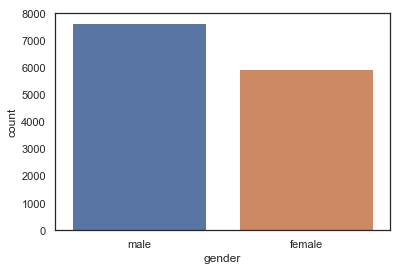

In [208]:
g = sns.countplot(df.gender)
df.gender.value_counts()

Average    7509
Good       3824
Bad        2240
Name: imagequality, dtype: int64

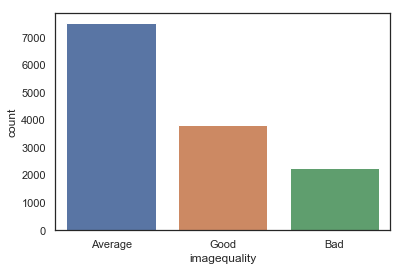

In [210]:
g = sns.countplot(df.imagequality)
df.imagequality.value_counts()

25-35    5411
35-45    3435
15-25    2494
45-55    1490
55+       743
Name: age, dtype: int64

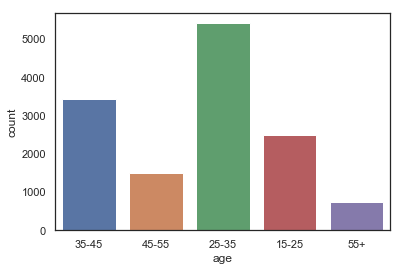

In [211]:
g = sns.countplot(df.age)
df.age.value_counts()

normal-healthy         8628
slightly-overweight    3196
over-weight             891
underweight             858
Name: weight, dtype: int64

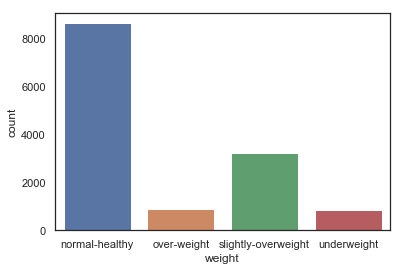

In [212]:
g = sns.countplot(df.weight)
df.weight.value_counts()

None                        7649
Daily/Office/Work Bag       4603
Grocery/Home/Plastic Bag    1321
Name: carryingbag, dtype: int64

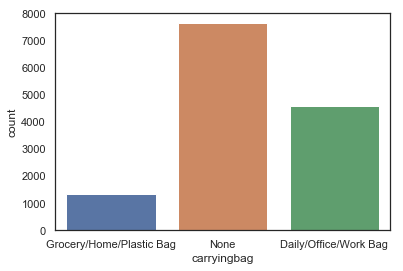

In [214]:
g = sns.countplot(df.carryingbag)
df.carryingbag.value_counts()

Normal     6038
CantSee    5028
Fancy      2507
Name: footwear, dtype: int64

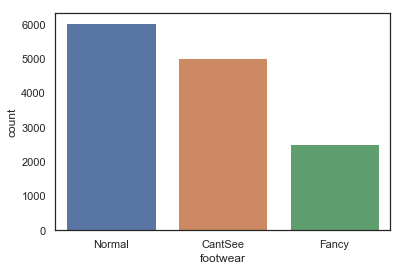

In [215]:
g = sns.countplot(df.footwear)
df.footwear.value_counts()

Neutral          9660
Happy            1609
Angry/Serious    1500
Sad               804
Name: emotion, dtype: int64

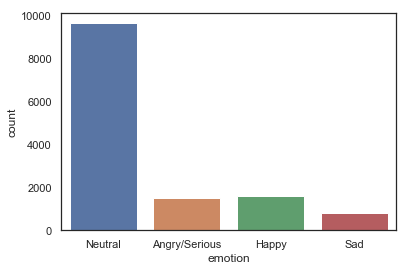

In [217]:
g = sns.countplot(df.emotion)
df.emotion.value_counts()

Front-Frontish    8383
Side              2983
Back              2207
Name: bodypose, dtype: int64

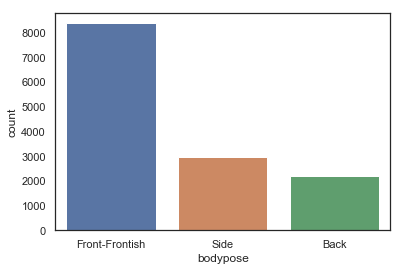

In [218]:
g = sns.countplot(df.bodypose)
df.bodypose.value_counts()

In [230]:
train_df.isnull().any().describe()

count        28
unique        1
top       False
freq         28
dtype: object

In [228]:
val_df.isnull().any().describe()

count        28
unique        1
top       False
freq         28
dtype: object

TypeError: Image data cannot be converted to float

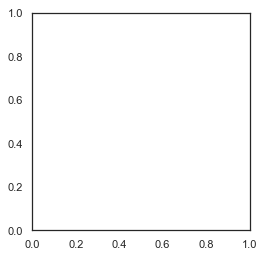

In [236]:
g = plt.imshow(df.gender[0][0][0])

In [62]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [47]:
backbone = VGG16(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(neck)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

## Exploratory analysis

In [88]:
df.describe()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
count,13573,13573,13573,13573,13573,13573,13573,13573,13573
unique,2,3,5,4,3,3,4,3,13573
top,male,Average,25-35,normal-healthy,None,Normal,Neutral,Front-Frontish,resized/5009.jpg
freq,7636,7509,5411,8628,7649,6038,9660,8383,1


In [90]:
df['age'].hist()

KeyboardInterrupt: 

In [89]:
one_hot_df.describe()

,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,...,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
count,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,...,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000,13573.000000
mean,0.437413,0.562587,0.553231,0.165034,0.281736,0.183747,0.398659,0.253076,0.109777,0.054741,...,0.370441,0.184705,0.444854,0.110514,0.118544,0.711707,0.059235,0.162602,0.617623,0.219775
std,0.496086,0.496086,0.497177,0.371224,0.449862,0.387292,0.489640,0.434790,0.312623,0.227482,...,0.482941,0.388072,0.496968,0.313540,0.323263,0.452985,0.236073,0.369016,0.485986,0.414109
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = False
    
for layer in backbone.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x000002F380579668> False
<keras.layers.convolutional.Conv2D object at 0x000002F3805796D8> False
<keras.layers.convolutional.Conv2D object at 0x000002F380579860> False
<keras.layers.pooling.MaxPooling2D object at 0x000002F380575518> False
<keras.layers.convolutional.Conv2D object at 0x000002F38058A748> False
<keras.layers.convolutional.Conv2D object at 0x000002F38058AF98> False
<keras.layers.pooling.MaxPooling2D object at 0x000002F380590CC0> False
<keras.layers.convolutional.Conv2D object at 0x000002F38059DCF8> False
<keras.layers.convolutional.Conv2D object at 0x000002F38059D438> False
<keras.layers.convolutional.Conv2D object at 0x000002F3805AA0B8> False
<keras.layers.pooling.MaxPooling2D object at 0x000002F3805B0BE0> False
<keras.layers.convolutional.Conv2D object at 0x000002F3805BDC18> False
<keras.layers.convolutional.Conv2D object at 0x000002F3805BD358> False
<keras.layers.convolutional.Conv2D object at 0x000002F3805CB208> False
<keras.

In [85]:
# Review model
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [53]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [13]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [14]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    # use_multiprocessing=False,
    # workers=1, 
    epochs=5,
    verbose=1
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





45/45 [==============================] - 1906s 42s/step - loss: 8.1628 - gender_output_loss: 0.7005 - image_quality_output_loss: 0.9988 - age_output_loss: 1.4681 - weight_output_loss: 1.0533 - bag_output_loss: 0.9649 - footwear_output_loss: 1.0137 - pose_output_loss: 0.9757 - emotion_output_loss: 0.9877 - gender_output_acc: 0.5385 - image_quality_output_acc: 0.5399 - age_output_acc: 0.3620 - weight_output_acc: 0.6175 - bag_output_acc: 0.5154 - footwear_output_acc: 0.4937 - pose_output_acc: 0.5894 - emotion_output_acc: 0.6853 - val_loss: 7.7467 - val_gender_output_loss: 0.6755 - val_image_quality_output_loss: 0.9673 - val_age_output_loss: 1.4358 - val_weight_output_loss: 0.9723 - val_bag_output_loss: 0.9084 - val_footwear_output_loss: 0.9559 - val_pose_output_loss: 0.9299 - val_emotion_output_loss: 0.9015 - val_gender_output_acc: 0.5701 - val_image_quality_output_acc: 0.5650 -

In [15]:
model

In [86]:
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

31/31 [==============================] - 314s 10s/step


{'age_output_acc': 0.18800403225806453,
 'age_output_loss': 1.829434125654159,
 'bag_output_acc': 0.3497983870967742,
 'bag_output_loss': 1.0211196637922717,
 'emotion_output_acc': 0.4314516129032258,
 'emotion_output_loss': 1.309355112814134,
 'footwear_output_acc': 0.43850806451612906,
 'footwear_output_loss': 1.1171580726100552,
 'gender_output_acc': 0.5317540322580645,
 'gender_output_loss': 0.6904636659929829,
 'image_quality_output_acc': 0.16381048387096775,
 'image_quality_output_loss': 1.2219822637496456,
 'loss': 9.657976888841198,
 'pose_output_acc': 0.5685483870967742,
 'pose_output_loss': 1.0369271962873396,
 'weight_output_acc': 0.07409274193548387,
 'weight_output_loss': 1.4315367514087307}

In [87]:
# Plot the model accuracy for each epoch.
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 8, figsize=(20, 5))

    # loss
    axes[0].plot(history.history['loss'], label='Training loss')
    axes[0].plot(history.history['val_loss'], label='Validation loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    # Age
    axes[1].plot(history.history['age_output_acc'], label='Age Train accuracy')
    axes[1].plot(history.history['val_age_output_acc'], label='Age Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()  
    
    # Gender
    axes[2].plot(history.history['gender_output_acc'], label='Gender Train accuracy')
    axes[2].plot(history.history['val_gender_output_acc'], label='Gener Val accuracy')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

    # Emotion
    axes[3].plot(history.history['emotion_output_acc'], label='Emotion Train accuracy')
    axes[3].plot(history.history['val_emotion_output_acc'], label='Emotion Val accuracy')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

    # weight
    axes[4].plot(history.history['weight_output_acc'], label='weight Train accuracy')
    axes[4].plot(history.history['val_weight_output_acc'], label='weight Val accuracy')
    axes[4].set_xlabel('Epochs')
    axes[4].legend()

    # bag
    axes[5].plot(history.history['bag_output_acc'], label='bag Train accuracy')
    axes[5].plot(history.history['val_bag_output_acc'], label='bag Val accuracy')
    axes[5].set_xlabel('Epochs')
    axes[5].legend()

    # footwear
    axes[6].plot(history.history['footwear_output_acc'], label='footwear Train accuracy')
    axes[6].plot(history.history['val_footwear_output_acc'], label='footwear Val accuracy')
    axes[6].set_xlabel('Epochs')
    axes[6].legend()

    # pose
    axes[7].plot(history.history['pose_output_acc'], label='pose Train accuracy')
    axes[7].plot(history.history['val_pose_output_acc'], label='pose Val accuracy')
    axes[7].set_xlabel('Epochs')
    axes[7].legend()

    # image_quality
    axes[8].plot(history.history['image_quality_output_acc'], label='image_quality Train accuracy')
    axes[8].plot(history.history['val_image_quality_output_acc'], label='image_quality Val accuracy')
    axes[8].set_xlabel('Epochs')
    axes[8].legend()

plot_train_history(H)
save_fig('modelX_accuracy') #CHANGE X NAME of image title for each model.

NameError: name 'history' is not defined

In [ ]:
filenames = df.image_path[image_index]
nb_samples = len(filenames)

fig=plt.figure()
columns = 4
rows = 4
for i in range(1, columns*rows -1):
    x_batch, y_batch = test_generator.next()

    name = model.predict(x_batch)
    name = np.argmax(name, axis=-1)
    true_name = y_batch
    true_name = np.argmax(true_name, axis=-1)

    label_map = (test_generator.class_indices)
    label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
    predictions = [label_map[k] for k in name]
    true_value = [label_map[k] for k in true_name]

    image = x_batch[0].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.title(str(predictions[0]) + ':' + str(true_value[0]))
    plt.imshow(image)
plt.show()

In [57]:
print(valid_gen)

In [64]:
# Utility functions

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [116]:
predictions= model.predict_generator(valid_gen)
'''predicted_class_indices=np.argmax(pred,axis=1)
labels = (valid_gen.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)'''

'predicted_class_indices=np.argmax(pred,axis=1)\nlabels = (valid_gen.class_indices)\nlabels2 = dict((v,k) for k,v in labels.items())\npredictions = [labels[k] for k in predicted_class_indices]\nprint(predicted_class_indices)\nprint (labels)\nprint (predictions)'

In [149]:
gender_labels = ['female', 'male']
print(gender_labels)

['female', 'male']


In [147]:
gender_preds_cls_idx = np.argmax(predictions[0][10], axis=-1)
print(gender_preds_cls_idx)
# 0 - female, 1- male

0


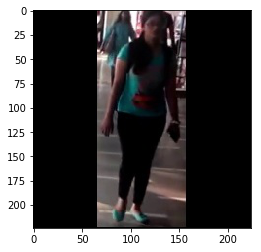

In [146]:
x = mpimg.imread(df.image_path[10])
plt.imshow(x)
plt.show()

In [166]:
len(predictions[0])

1984

1
0


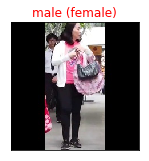

'ax.set_title("{} ({})".format(gender[gender_pred_index], \n                                  gender[gender_true_index]),\n                                  color=("green" if gender_pred_index == gender_true_index else "red"))'

In [168]:
figure = plt.figure(figsize=(20, 8))
ax = figure.add_subplot(3, 5, 1 + 1, xticks=[], yticks=[])

recordIndex = 500
gender = ['female', 'male']
gender_pred_index = np.argmax(predictions[0][recordIndex], axis=-1)
gender_true_index = gender.index(df.gender[recordIndex])

print(gender_pred_index)
print(gender_true_index)


x = mpimg.imread(df.image_path[recordIndex])
plt.imshow(x)

#ax.set_title('Sex - Actual: , Pred: ')
ax.set_title("{} ({})".format(gender[gender_pred_index], 
                                  gender[gender_true_index]),
                                  color=("green" if gender_pred_index == gender_true_index else "red"))
plt.show()
'''ax.set_title("{} ({})".format(gender[gender_pred_index], 
                                  gender[gender_true_index]),
                                  color=("green" if gender_pred_index == gender_true_index else "red"))'''

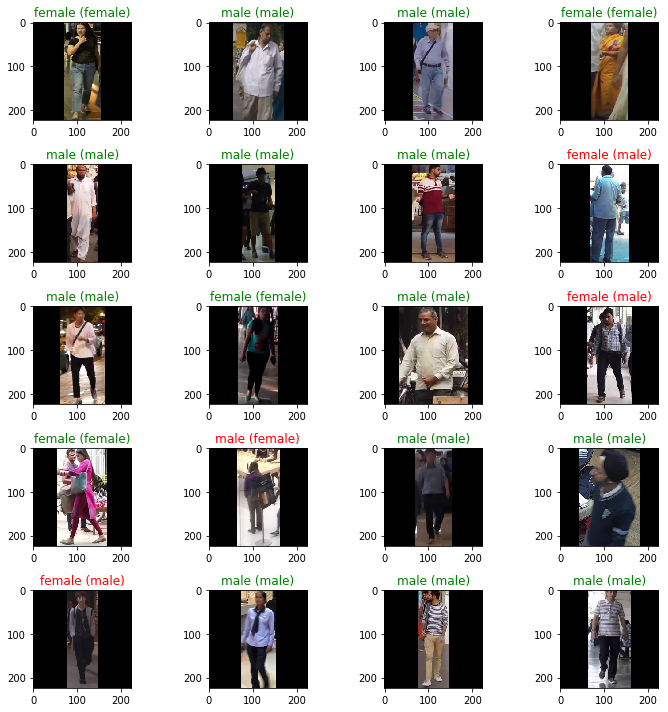

Attributes of image at index: 500
gender                         female
imagequality                     Good
age                             45-55
weight                 normal-healthy
carryingbag     Daily/Office/Work Bag
footwear                        Fancy
emotion                       Neutral
bodypose               Front-Frontish
image_path            resized/501.jpg
Name: 500, dtype: object


In [178]:
# Print predictions - gender
fig = plt.figure(figsize=(10, 10))

columns = 4
rows = 5
ax = []
gender = ['female', 'male']

for i in range(1, columns * rows + 1):
    
    gender_pred_index = np.argmax(predictions[0][i], axis=-1)
    gender_true_index = gender.index(df.gender[i])
    
    x = mpimg.imread(df.image_path[i])
    ax.append(fig.add_subplot(rows, columns, i))
    fig.tight_layout() 
    ax[-1].set_title("{} ({})".format(gender[gender_pred_index], 
                                  gender[gender_true_index]),
                                  color=("green" if gender_pred_index == gender_true_index else "red"))
    plt.imshow(x)

plt.show()

In [179]:
def get_misclassified_gender(predictions):
  print("Total predictions: "+str(len(predictions[0])))
  misclassifieds = []
  for i in range(len(predictions[0])):
    
    # Index 0 corresponds to gender
    gender_pred_index = np.argmax(predictions[0][i], axis=-1)
    gender_true_index = gender.index(df.gender[i])
    if gender_pred_index == gender_true_index:
      misclassifieds.append(i)

  print("Total Misclassifieds: "+str(len(misclassifieds)))

get_misclassified_gender(predictions)

Total predictions: 1984
Total Misclassifieds: 1111
